In [1]:
import numpy as np
import pandas as pd   
import datetime
import matplotlib.pyplot as plt
import pickle

from sklearn.metrics import mean_absolute_error, accuracy_score
from sklearn.preprocessing import MinMaxScaler

import sys
sys.path.insert(0,'..')
import module as mod

from keras.layers import Dropout, Layer, LSTM, Dense, BatchNormalization, Activation, Input
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras import backend as K

#from kerashypetune import KerasGridSearch

This notebook is an adaptation of the following Git repository : https://github.com/cerlymarco/MEDIUM_NoteBook/tree/master/Time2Vec

# 0. Load and prepare our dataset
First we declare our global variables

In [2]:
### DEFINE GLOBAL VARIABLES ###
TIME_STEP = datetime.timedelta(minutes=1, seconds=30) # duration of a step in the resample dataset, originally 1 second
DURATION_TIME = datetime.timedelta(minutes=60) # duration of a sequence
OVERLAP_PERIOD_PERCENT = 0.8 # 0.5 <=> 50% overlapping

SEQUENCE_LENGTH, OVERLAP_PERIOD = mod.convertToSequenceParameters(TIME_STEP, DURATION_TIME, OVERLAP_PERIOD_PERCENT)

Then we load our datasets

In [3]:
### READ DATA ###

house1_power_blk2 = mod.load_dataset('house1_power_blk2_labels.zip', resample_period=TIME_STEP)
#house1_power_blk2['activity'] = (house1_power_blk2['activity'] > 0.5).astype(int)
house2_power_blk1 = mod.load_dataset('house2_power_blk1_labels.zip', resample_period=TIME_STEP)
#house2_power_blk1['activity'] = (house2_power_blk1['activity'] > 0.5).astype(int)
house1_power_blk2.head()

,mains,activity,hour
datetime,,,
2016-03-06 00:00:00,473.0,0,0.000000
2016-03-06 00:01:30,483.0,0,0.016667
2016-03-06 00:03:00,474.0,0,0.050000
2016-03-06 00:04:30,483.0,0,0.066667
2016-03-06 00:06:00,477.0,0,0.100000


In [4]:
house2_power_ukdale = mod.load_dataset('ukdale/house2_power_labels.zip', resample_period=TIME_STEP).interpolate('linear')
house2_power_ukdale['activity'] = (house2_power_ukdale['activity'] > 0.5).astype(int)
house2_power_ukdale.head()

,mains,activity,hour
datetime,,,
2013-05-20 21:27:00,92.600000,0,21.450000
2013-05-20 21:28:30,170.391665,0,21.466667
2013-05-20 21:30:00,248.183330,0,21.500000
2013-05-20 21:31:30,248.375000,0,21.516667
2013-05-20 21:33:00,248.566670,0,21.550000


We'll normalize each dataset with a ```MinMaxScaler``` fitted on 70% of each dataset which we'll use a train set. After a few tests, normalizing the electrical power data is necessary to get better results for our final classification, more specifically to use one house as a training dataset and another as a testing dataset.

In [5]:
### SCALE THE DATASETS ###

step = SEQUENCE_LENGTH - OVERLAP_PERIOD

# scale the dataset
train_dim_h1 = int(0.7*len(house1_power_blk2) / step)
train_dim_h2 = int(0.7*len(house2_power_blk1) / step)
train_dim_h2_ukd = int(0.1*len(house2_power_ukdale) / step)

scaler = MinMaxScaler()
scaler.fit(house1_power_blk2['mains'].iloc[:train_dim_h1*step].values.reshape(-1, 1))
house1_power_blk2['mains'] = scaler.transform(house1_power_blk2['mains'].values.reshape(-1, 1))
#house1_power_blk2['off_peak'] = ((house1_power_blk2['hour'] > 6) & (house1_power_blk2['hour'] < 23)).astype(int)

scaler = MinMaxScaler()
scaler.fit(house2_power_blk1['mains'].iloc[:train_dim_h2*step].values.reshape(-1, 1))
house2_power_blk1['mains'] = scaler.transform(house2_power_blk1['mains'].values.reshape(-1, 1))
#house2_power_blk1['off_peak'] = ((house2_power_blk1['hour'] > 6) & (house2_power_blk1['hour'] < 23)).astype(int)

scaler = MinMaxScaler()
scaler.fit(house2_power_ukdale['mains'].iloc[:train_dim_h2_ukd*step].values.reshape(-1, 1))
house2_power_ukdale['mains'] = scaler.transform(house2_power_ukdale['mains'].values.reshape(-1, 1))

house1_power_blk2.head()

,mains,activity,hour
datetime,,,
2016-03-06 00:00:00,0.024562,0,0.000000
2016-03-06 00:01:30,0.025599,0,0.016667
2016-03-06 00:03:00,0.024666,0,0.050000
2016-03-06 00:04:30,0.025599,0,0.066667
2016-03-06 00:06:00,0.024977,0,0.100000


In [6]:
print(f"Nombre de jours utilisés pour le scaler maison 1: {house1_power_blk2.index[train_dim_h1*step] - house1_power_blk2.index[0]}")
print(f"Nombre de jours utilisés pour le scaler maison 2: {house2_power_blk1.index[train_dim_h2*step] - house2_power_blk1.index[0]}")
print(f"Nombre de jours utilisés pour le scaler maison 2 ukdale: {house2_power_ukdale.index[train_dim_h2_ukd*step] - house2_power_ukdale.index[0]}")

Nombre de jours utilisés pour le scaler maison 1: 44 days 01:36:00
Nombre de jours utilisés pour le scaler maison 2: 41 days 07:48:00
Nombre de jours utilisés pour le scaler maison 2 ukdale: 14 days 05:24:00


In [7]:
### CREATE GENERATOR FOR LSTM AND T2V ###

# we define a function to generate our sequences
def gen_sequence(id_df, seq_length, overlap_period, seq_cols):
    
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]
    step = seq_length - overlap_period

    for start, stop in zip(range(0, num_elements-seq_length, step), range(seq_length, num_elements, step)):
        yield data_matrix[start:stop, :]

# this function is usefull in the case that we only predict 1 data point for each sequence
def gen_labels(id_df, seq_length, overlap_period, label):
    
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    step = seq_length - overlap_period
    
    return data_matrix[seq_length:num_elements:step, :]

# we define a utility function to unfold our sequences
def unfold_sequence(y_seq, seq_length, overlap_period):
    step = seq_length - overlap_period
    y_unfolded = np.zeros((y_seq.shape[0]*step, ))
    y_weight = np.zeros((y_seq.shape[0]*step, ))

    for i in range(seq_length):
        y_unfolded[i::step] += y_seq[:-int(i/step) if int(i/step) > 0 else None,i,0]
        y_weight[i::step] += 1

    return y_unfolded/y_weight

# 1. Train our embeddings

Next we need to prepare the data in batches for Keras.

In [8]:
### HOUSE 1 ###
X_h1, Y_h1 = [], []
for sequence in gen_sequence(house1_power_blk2, SEQUENCE_LENGTH, OVERLAP_PERIOD, ['mains']):
    X_h1.append(sequence)
    
    # gen_labels
for sequence in gen_sequence(house1_power_blk2, SEQUENCE_LENGTH, OVERLAP_PERIOD, ['mains']):
    Y_h1.append(sequence)
    
X_h1 = np.asarray(X_h1)
Y_h1 = np.asarray(Y_h1)

In [9]:
### HOUSE 2 ###

# prepare the batches
X_h2, Y_h2 = [], []
for sequence in gen_sequence(house2_power_blk1, SEQUENCE_LENGTH, OVERLAP_PERIOD, ['mains']):
    X_h2.append(sequence)
    
for sequence in gen_sequence(house2_power_blk1, SEQUENCE_LENGTH, OVERLAP_PERIOD, ['mains']):
    Y_h2.append(sequence)
    
X_h2 = np.asarray(X_h2)
Y_h2 = np.asarray(Y_h2)

In [10]:
### HOUSE 2 UKDALE ###

# prepare the batches
X_h2_ukd, Y_h2_ukd = [], []
for sequence in gen_sequence(house2_power_ukdale, SEQUENCE_LENGTH, OVERLAP_PERIOD, ['mains']):
    X_h2_ukd.append(sequence)
    
for sequence in gen_sequence(house2_power_ukdale, SEQUENCE_LENGTH, OVERLAP_PERIOD, ['mains']):
    Y_h2_ukd.append(sequence)
    
X_h2_ukd = np.asarray(X_h2_ukd)
Y_h2_ukd = np.asarray(Y_h2_ukd)

In [11]:
### TRAIN TEST SPLIT HOUSE 1 ###
X_train_h1, X_test_h1 = X_h1[:train_dim_h1], X_h1[train_dim_h1:]
y_train_h1, y_test_h1 = Y_h1[:train_dim_h1], Y_h1[train_dim_h1:]

print(X_train_h1.shape, y_train_h1.shape)
print(X_test_h1.shape, y_test_h1.shape)

(5288, 40, 1) (5288, 40, 1)
(2262, 40, 1) (2262, 40, 1)


In [12]:
### TRAIN TEST SPLIT HOUSE 2 ###

X_train_h2, X_test_h2 = X_h2[:train_dim_h2], X_h2[train_dim_h2:]
y_train_h2, y_test_h2 = Y_h2[:train_dim_h2], Y_h2[train_dim_h2:]

print(X_train_h2.shape, y_train_h2.shape)
print(X_test_h2.shape, y_test_h2.shape)

(4959, 40, 1) (4959, 40, 1)
(2121, 40, 1) (2121, 40, 1)


In [13]:
### TRAIN TEST SPLIT HOUSE 2 UKDALE ###

X_train_h2_ukd, X_test_h2_ukd = X_h2_ukd[:train_dim_h2_ukd], X_h2_ukd[train_dim_h2_ukd:]
y_train_h2_ukd, y_test_h2_ukd = Y_h2_ukd[:train_dim_h2_ukd], Y_h2_ukd[train_dim_h2_ukd:]

print(X_train_h2_ukd.shape, y_train_h2_ukd.shape)
print(X_test_h2_ukd.shape, y_test_h2_ukd.shape)

(1707, 40, 1) (1707, 40, 1)
(15368, 40, 1) (15368, 40, 1)


In [14]:
### DEFINE T2V LAYER ###

class T2V(Layer):
    
    def __init__(self, output_dim=None, **kwargs):
        self.output_dim = output_dim
        super(T2V, self).__init__(**kwargs)
        
    def build(self, input_shape):

        self.W = self.add_weight(name='W',
                                shape=(input_shape[-1], self.output_dim),
                                initializer='uniform',
                                trainable=True)

        self.P = self.add_weight(name='P',
                                shape=(input_shape[1], self.output_dim),
                                initializer='uniform',
                                trainable=True)

        self.w = self.add_weight(name='w',
                                shape=(input_shape[1], 1),
                                initializer='uniform',
                                trainable=True)

        self.p = self.add_weight(name='p',
                                shape=(input_shape[1], 1),
                                initializer='uniform',
                                trainable=True)

        super(T2V, self).build(input_shape)
        
    def call(self, x):
        
        original = self.w * x + self.p
        sin_trans = K.sin(K.dot(x, self.W) + self.P)
        
        return K.concatenate([sin_trans, original], -1)

In [15]:
### DEFINE MODEL STRUCTURES ###

def T2V_NN(param, dim):
    
    inp = Input(shape=(dim,1))
    #x = Dropout(0.2)(inp)
    x = T2V(param['t2v_dim'])(inp)
    x = Dropout(0.2)(x)
    # return_sequences=False : ne retourne que le dernier état
    x = LSTM(param['unit'], activation=param['act'], return_sequences=True)(x)
    x = Dense(1)(x)
    
    m = Model(inp, x)
    m.compile(loss='mse', optimizer='adam') #Adam(learning_rate=param['lr'])
    m.optimizer.lr.assign(param['lr'])
    
    return m

In [16]:
### DEFINE PARAM GRID FOR HYPERPARM OPTIMIZATION ###

early_stop = EarlyStopping(patience=3, verbose=0, min_delta=0.0001, monitor='loss', mode='auto', restore_best_weights=True)

best_params = {'unit': 32, 't2v_dim': 128, 'lr': 0.001, 'act': 'leaky_relu', 'epochs': 10, 'batch_size': 1024}
kgs_t2v = T2V_NN(param=best_params, dim=SEQUENCE_LENGTH)
kgs_t2v.summary();

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 40, 1)]           0         
                                                                 
 t2v (T2V)                   (None, 40, 129)           5328      
                                                                 
 dropout (Dropout)           (None, 40, 129)           0         
                                                                 
 lstm (LSTM)                 (None, 40, 32)            20736     
                                                                 
 dense (Dense)               (None, 40, 1)             33        
                                                                 
Total params: 26,097
Trainable params: 26,097
Non-trainable params: 0
_________________________________________________________________


2022-06-27 16:41:52.241873: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-27 16:41:52.248252: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-27 16:41:52.248434: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-27 16:41:52.249031: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [17]:
### TRAIN MODEL ON HOUSE 1 ###
kgs_t2v.fit(X_train_h1, y_train_h1, epochs=best_params['epochs'], batch_size=best_params['batch_size'], callbacks=[early_stop]);

Epoch 1/10
6/6 [==============================] - 2s 38ms/step - loss: 0.0178
Epoch 2/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0105
Epoch 3/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0097
Epoch 4/10
6/6 [==============================] - 0s 37ms/step - loss: 0.0079
Epoch 5/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0066
Epoch 6/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0050
Epoch 7/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0034
Epoch 8/10
6/6 [==============================] - 0s 41ms/step - loss: 0.0024
Epoch 9/10
6/6 [==============================] - 0s 40ms/step - loss: 0.0022
Epoch 10/10
6/6 [==============================] - 0s 42ms/step - loss: 0.0019


In [18]:
### SAVE/LOAD THE T2V LAYER ###
t2v_weights = kgs_t2v.layers[1].get_weights()

In [19]:
### TRAIN MODEL ON HOUSE 2 ###
kgs_t2v.fit(X_train_h2, y_train_h2, epochs=best_params['epochs'], batch_size=best_params['batch_size'], callbacks=[early_stop]);

# save the weights
t2v_weights = kgs_t2v.layers[1].get_weights()
# pickle.dump(t2v_weights, open('t2v_weights_norm_lstm_house2_1m30.pkl', 'wb'))
#t2v_weights = pickle.load(open('t2v_weights_norm_lstm_house2_1m30.pkl', 'rb'))
#kgs_t2v.layers[1].set_weights(t2v_weights)

Epoch 1/10
5/5 [==============================] - 0s 39ms/step - loss: 0.0014
Epoch 2/10
5/5 [==============================] - 0s 36ms/step - loss: 0.0013
Epoch 3/10
5/5 [==============================] - 0s 41ms/step - loss: 0.0012
Epoch 4/10
5/5 [==============================] - 0s 37ms/step - loss: 0.0012
Epoch 5/10
5/5 [==============================] - 0s 47ms/step - loss: 0.0011
Epoch 6/10
5/5 [==============================] - 0s 41ms/step - loss: 0.0011
Epoch 7/10
5/5 [==============================] - 0s 38ms/step - loss: 9.9962e-04
Epoch 8/10
5/5 [==============================] - 0s 37ms/step - loss: 9.4868e-04
Epoch 9/10
5/5 [==============================] - 0s 37ms/step - loss: 8.8431e-04
Epoch 10/10
5/5 [==============================] - 0s 39ms/step - loss: 8.0536e-04


In [20]:
### TRAIN MODEL ON HOUSE 2 UK DALE ###
# decrease learning rate
K.set_value(kgs_t2v.optimizer.learning_rate, 0.0001)
kgs_t2v.fit(X_train_h2_ukd, y_train_h2_ukd, epochs=best_params['epochs'], batch_size=best_params['batch_size'], callbacks=[early_stop]);

# save the weights
t2v_weights = kgs_t2v.layers[1].get_weights()

Epoch 1/10
2/2 [==============================] - 0s 51ms/step - loss: 8.6070e-04
Epoch 2/10
2/2 [==============================] - 0s 39ms/step - loss: 8.6005e-04
Epoch 3/10
2/2 [==============================] - 0s 46ms/step - loss: 8.6168e-04
Epoch 4/10
2/2 [==============================] - 0s 43ms/step - loss: 8.3989e-04


In [21]:
### MSE ON HOUSE 1 ###
y_pred_h1 = kgs_t2v.predict(X_test_h1)
mean_absolute_error(y_test_h1.ravel(), y_pred_h1.ravel())

0.010255630681294507

In [22]:
### MSE ON HOUSE 2 ###
y_pred_h2 = kgs_t2v.predict(X_test_h2)
mean_absolute_error(y_test_h2.ravel(), y_pred_h2.ravel())

0.008142321291878534

In [23]:
### MSE ON HOUSE 2 UKDALE ###
y_pred_h2_ukd = kgs_t2v.predict(X_test_h2_ukd)
mean_absolute_error(y_test_h2_ukd.ravel(), y_pred_h2_ukd.ravel())

0.007891502758914985

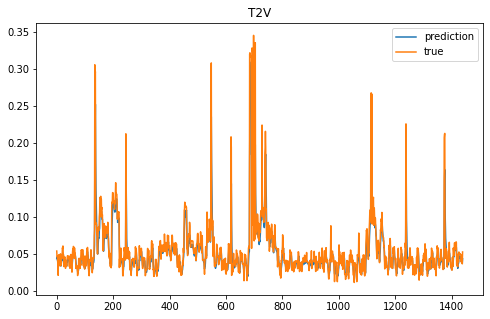

In [24]:
### VISUALIZE TEST PREDICTIONS ON HOUSE 1 ###

plt.figure(figsize=(8,5))

y_pred_unfolded_h1 = unfold_sequence(y_pred_h1, SEQUENCE_LENGTH, OVERLAP_PERIOD)
y_test_unfolded_h1 = unfold_sequence(y_test_h1, SEQUENCE_LENGTH, OVERLAP_PERIOD)

plt.plot(y_pred_unfolded_h1[:24*60], label='prediction')
plt.plot(y_test_unfolded_h1[:24*60], label='true')
plt.title('T2V');
plt.legend();

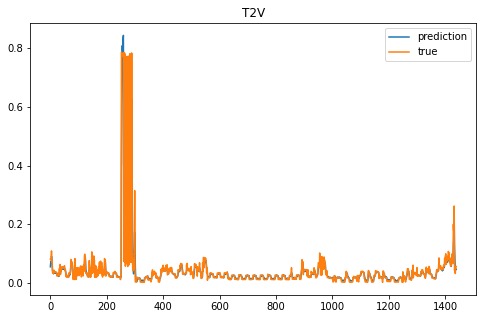

In [25]:
### VISUALIZE TEST PREDICTIONS ON HOUSE 2 ###

plt.figure(figsize=(8,5))

y_pred_unfolded_h2 = unfold_sequence(y_pred_h2, SEQUENCE_LENGTH, OVERLAP_PERIOD)
y_test_unfolded_h2 = unfold_sequence(y_test_h2, SEQUENCE_LENGTH, OVERLAP_PERIOD)

plt.plot(y_pred_unfolded_h2[:24*60], label='prediction')
plt.plot(y_test_unfolded_h2[:24*60], label='true')
plt.title('T2V');
plt.legend();

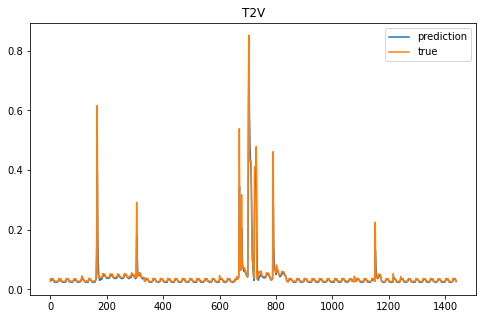

In [26]:
### VISUALIZE TEST PREDICTIONS ON HOUSE 2 UKDALE ###

plt.figure(figsize=(8,5))

y_pred_unfolded_h2_ukd = unfold_sequence(y_pred_h2_ukd, SEQUENCE_LENGTH, OVERLAP_PERIOD)
y_test_unfolded_h2_ukd = unfold_sequence(y_test_h2_ukd, SEQUENCE_LENGTH, OVERLAP_PERIOD)

plt.plot(y_pred_unfolded_h2_ukd[:24*60], label='prediction')
plt.plot(y_test_unfolded_h2_ukd[:24*60], label='true')
plt.title('T2V');
plt.legend();

Now that our Time2Vec model is trained, we can use its embedding as a first layer of neural network for a binary classification task.

# 2. Using our embeddings for classification

In [27]:
def get_scores(y_test, y_pred, dataset, seq_length, overlap_period, train_dim_ratio=0.7):
    y_pred_unfolded = unfold_sequence(y_pred, seq_length, overlap_period)
    y_test_unfolded = unfold_sequence(y_test, seq_length, overlap_period)

    mod.plot_confusion_matrix(y_test_unfolded, (y_pred_unfolded>0.5).astype(int));

    train_dim_tot = int(train_dim_ratio*len(dataset))
    
    dataset_res = dataset.copy()
    dataset_res['activity_pred'] = np.nan

    offset = len(dataset_res.iloc[train_dim_tot:, :]) - len(y_pred_unfolded)
    dataset_res.iloc[train_dim_tot:-offset, -1] = (y_pred_unfolded > 0.5).astype(int)
    
    # plot the confusion matrices
    fig, ax = plt.subplots()

    mod.plot_activity_hist(dataset_res['activity_pred'].iloc[train_dim_tot:-offset] , figsize=(12, 6), alpha=0.5, label='predictions', ax=ax) 
    mod.plot_activity_hist(dataset['activity'].iloc[train_dim_tot:-offset], figsize=(12, 6), alpha=0.5, label='truth', color='tab:orange', ax=ax)

    # plot the confusion metric
    pred = pd.DataFrame()
    df_gt = pd.DataFrame()

    pred[['timestamp', 'activity_prediction']] = dataset_res.reset_index()[['datetime', 'activity_pred']].iloc[train_dim_tot:-offset]
    df_gt[['timestamp', 'activity_true']] = dataset_res.reset_index()[['datetime', 'activity']].iloc[train_dim_tot:-offset]
    mod.eval_metric(pred, df_gt)

In [28]:
X_h2, Y_h2 = [], []
for sequence in gen_sequence(house2_power_blk1, SEQUENCE_LENGTH, OVERLAP_PERIOD, ['mains']):
    X_h2.append(sequence)

# gen_labels
for sequence in gen_sequence(house2_power_blk1, SEQUENCE_LENGTH, OVERLAP_PERIOD, ['activity']):
    Y_h2.append(sequence)
    
X_h2 = np.asarray(X_h2)
Y_h2 = np.asarray(Y_h2)

In [29]:
### TRAIN TEST SPLIT ###
step = SEQUENCE_LENGTH - OVERLAP_PERIOD
train_dim_h2 = int(0.7*len(house2_power_blk1) / step)
X_train_h2, X_test_h2 = X_h2[:train_dim_h2], X_h2[train_dim_h2:]
y_train_h2, y_test_h2 = Y_h2[:train_dim_h2], Y_h2[train_dim_h2:]

print(X_train_h2.shape, y_train_h2.shape)
print(X_test_h2.shape, y_test_h2.shape)

(4959, 40, 1) (4959, 40, 1)
(2121, 40, 1) (2121, 40, 1)


In [30]:
X_h1, Y_h1 = [], []
for sequence in gen_sequence(house1_power_blk2, SEQUENCE_LENGTH, OVERLAP_PERIOD, ['mains']):
    X_h1.append(sequence)

# gen_labels
for sequence in gen_sequence(house1_power_blk2, SEQUENCE_LENGTH, OVERLAP_PERIOD, ['activity']):
    Y_h1.append(sequence)
    
X_h1 = np.asarray(X_h1)
Y_h1 = np.asarray(Y_h1)

In [31]:
### TRAIN TEST SPLIT ###
step = SEQUENCE_LENGTH - OVERLAP_PERIOD
train_dim_h1 = int(0.7*len(house1_power_blk2) / step)
X_train_h1, X_test_h1 = X_h1[:train_dim_h1], X_h1[train_dim_h1:]
y_train_h1, y_test_h1 = Y_h1[:train_dim_h1], Y_h1[train_dim_h1:]

print(X_train_h1.shape, y_train_h1.shape)
print(X_test_h1.shape, y_test_h1.shape)

(5288, 40, 1) (5288, 40, 1)
(2262, 40, 1) (2262, 40, 1)


In [32]:
X_h2_ukd, Y_h2_ukd = [], []
for sequence in gen_sequence(house2_power_ukdale, SEQUENCE_LENGTH, OVERLAP_PERIOD, ['mains']):
    X_h2_ukd.append(sequence)

# gen_labels
for sequence in gen_sequence(house2_power_ukdale, SEQUENCE_LENGTH, OVERLAP_PERIOD, ['activity']):
    Y_h2_ukd.append(sequence)
    
X_h2_ukd = np.asarray(X_h2_ukd)
Y_h2_ukd = np.asarray(Y_h2_ukd)

In [33]:
### TRAIN TEST SPLIT ###
step = SEQUENCE_LENGTH - OVERLAP_PERIOD
train_dim_h2_ukd = int(0.1*len(house2_power_ukdale) / step)
X_train_h2_ukd, X_test_h2_ukd = X_h2_ukd[:train_dim_h2_ukd], X_h2_ukd[train_dim_h2_ukd:]
y_train_h2_ukd, y_test_h2_ukd = Y_h2_ukd[:train_dim_h2_ukd], Y_h2_ukd[train_dim_h2_ukd:]

print(X_train_h2_ukd.shape, y_train_h2_ukd.shape)
print(X_test_h2_ukd.shape, y_test_h2_ukd.shape)

(1707, 40, 1) (1707, 40, 1)
(15368, 40, 1) (15368, 40, 1)


In [34]:
### RE-DEFINE T2V LAYER ###

class T2V(Layer):
    
    def __init__(self, output_dim=None, **kwargs):
        self.output_dim = output_dim
        super(T2V, self).__init__(**kwargs)
        
    def build(self, input_shape):

        self.W = self.add_weight(name='W',
                                shape=(input_shape[-1], self.output_dim),
                                initializer='uniform',
                                trainable=True)

        self.P = self.add_weight(name='P',
                                shape=(input_shape[1], self.output_dim),
                                initializer='uniform',
                                trainable=True)

        self.w = self.add_weight(name='w',
                                shape=(input_shape[1], 1),
                                initializer='uniform',
                                trainable=True)

        self.p = self.add_weight(name='p',
                                shape=(input_shape[1], 1),
                                initializer='uniform',
                                trainable=True)

        super(T2V, self).build(input_shape)
        
    def call(self, x):
        
        original = self.w * x + self.p
        sin_trans = K.sin(K.dot(x, self.W) + self.P)
        
        return K.concatenate([sin_trans, original], -1)

In [35]:
### DEFINE CLASSIFICATION MODEL STRUCTURES ###

def T2V_NN_C(param, dim):
    
    # set_seed(33)
    
    inp = Input(shape=(dim,1))
    #x = Dropout(0.2)(inp)
    x = T2V(param['t2v_dim'])(inp)
    x = Dropout(0.2)(x)
    x = LSTM(param['unit'], activation=param['act'], return_sequences=True)(x)
    # we want to make a classification with 2 classes
    x = Dense(1, activation='sigmoid')(x)
    #x = BatchNormalization()(x)
    #x = Activation('sigmoid')(x)
    
    m = Model(inp, x)
    m.compile(loss='bce', optimizer='adam') #Adam(learning_rate=param['lr'])
    m.optimizer.lr.assign(param['lr'])
    
    return m

In [36]:
### LOAD OUR WEIGHTS ###
#t2v_weights = pickle.load(open('t2v_weights_norm_lstm_house2.pkl', 'rb'))
t2v_weights = kgs_t2v.layers[1].get_weights()

early_stop = EarlyStopping(patience=5, verbose=0, min_delta=0.0001, monitor='loss', mode='auto', restore_best_weights=True)
best_params = {'unit': 32, 't2v_dim': 128, 'epochs': 16, 'lr':0.0001, 'act': 'leaky_relu', 'batch_size': 1024}
kgs_t2v_c = T2V_NN_C(param=best_params, dim=SEQUENCE_LENGTH)

kgs_t2v_c.layers[1].set_weights(t2v_weights)

# to ensable fine-tuning
kgs_t2v_c.layers[1].trainable = False

kgs_t2v_c.summary();

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 40, 1)]           0         
                                                                 
 t2v_1 (T2V)                 (None, 40, 129)           5328      
                                                                 
 dropout_1 (Dropout)         (None, 40, 129)           0         
                                                                 
 lstm_1 (LSTM)               (None, 40, 32)            20736     
                                                                 
 dense_1 (Dense)             (None, 40, 1)             33        
                                                                 
Total params: 26,097
Trainable params: 20,769
Non-trainable params: 5,328
_________________________________________________________________


Let's train our model on house 1.

In [37]:
kgs_t2v_c.fit(X_train_h1, y_train_h1, epochs=best_params['epochs'], batch_size=best_params['batch_size'], callbacks=[early_stop]);

Epoch 1/16
6/6 [==============================] - 1s 38ms/step - loss: 0.6933
Epoch 2/16
6/6 [==============================] - 0s 44ms/step - loss: 0.6929
Epoch 3/16
6/6 [==============================] - 0s 43ms/step - loss: 0.6925
Epoch 4/16
6/6 [==============================] - 0s 39ms/step - loss: 0.6922
Epoch 5/16
6/6 [==============================] - 0s 40ms/step - loss: 0.6918
Epoch 6/16
6/6 [==============================] - 0s 42ms/step - loss: 0.6914
Epoch 7/16
6/6 [==============================] - 0s 37ms/step - loss: 0.6910
Epoch 8/16
6/6 [==============================] - 0s 37ms/step - loss: 0.6906
Epoch 9/16
6/6 [==============================] - 0s 49ms/step - loss: 0.6902
Epoch 10/16
6/6 [==============================] - 0s 46ms/step - loss: 0.6897
Epoch 11/16
6/6 [==============================] - 0s 50ms/step - loss: 0.6891
Epoch 12/16
6/6 [==============================] - 0s 38ms/step - loss: 0.6886
Epoch 13/16
6/6 [==============================] - 0s 38ms/st

Let's train our model on house 2.

In [38]:
kgs_t2v_c.fit(X_train_h1, y_train_h1, epochs=best_params['epochs'], batch_size=best_params['batch_size'], callbacks=[early_stop]);

Epoch 1/16
6/6 [==============================] - 0s 42ms/step - loss: 0.6849
Epoch 2/16
6/6 [==============================] - 0s 46ms/step - loss: 0.6839
Epoch 3/16
6/6 [==============================] - 0s 40ms/step - loss: 0.6828
Epoch 4/16
6/6 [==============================] - 0s 44ms/step - loss: 0.6814
Epoch 5/16
6/6 [==============================] - 0s 39ms/step - loss: 0.6800
Epoch 6/16
6/6 [==============================] - 0s 46ms/step - loss: 0.6782
Epoch 7/16
6/6 [==============================] - 0s 42ms/step - loss: 0.6762
Epoch 8/16
6/6 [==============================] - 0s 42ms/step - loss: 0.6738
Epoch 9/16
6/6 [==============================] - 0s 44ms/step - loss: 0.6708
Epoch 10/16
6/6 [==============================] - 0s 48ms/step - loss: 0.6672
Epoch 11/16
6/6 [==============================] - 0s 40ms/step - loss: 0.6632
Epoch 12/16
6/6 [==============================] - 0s 43ms/step - loss: 0.6613
Epoch 13/16
6/6 [==============================] - 0s 39ms/st

We can now make predictions and have a look at the performances. Let's have a look at the score on the test dataset from house 1.

Score f_beta : 73.271%
Score accuracy : 73.315%


/mnt/data/Documents/Cours Télécom/INFMDI780 - Projet Fil Rouge/Activity_Detection_From_Electrical_Consumption_Load_Curves/Time2Vec/../module.py:529: RuntimeWarning: invalid value encountered in double_scalars
  IoU = I/U


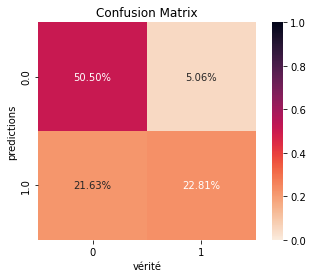

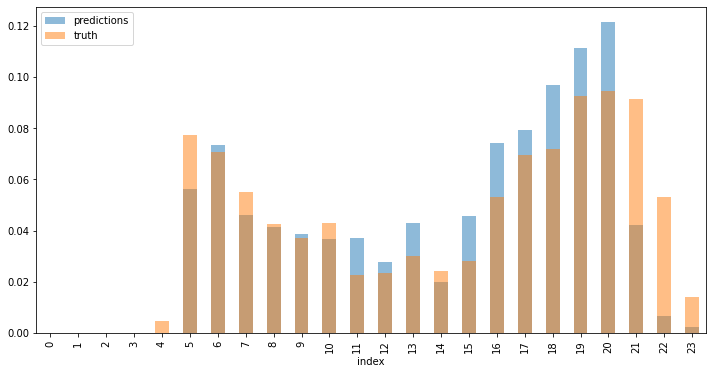

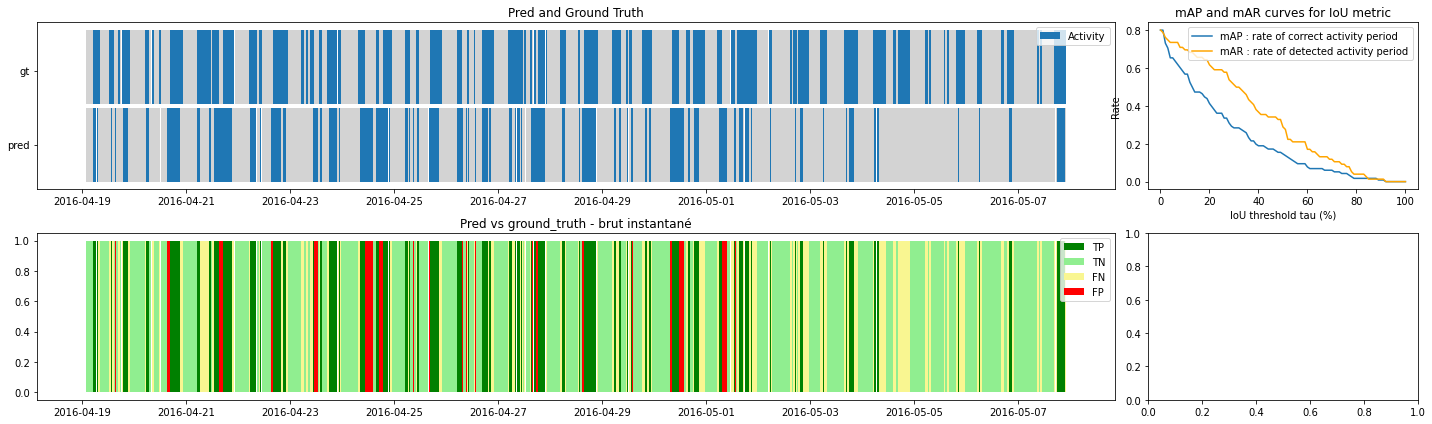

In [39]:
y_pred_h1 = kgs_t2v_c.predict(X_test_h1)
get_scores(y_test_h1, y_pred_h1, house1_power_blk2, SEQUENCE_LENGTH, OVERLAP_PERIOD)

Now let's have a look at the score on the test dataset from house 2.

Score f_beta : 61.134%
Score accuracy : 65.005%


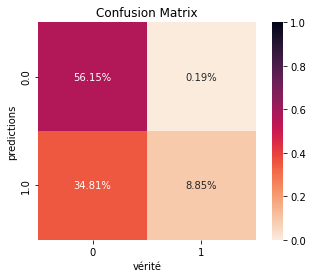

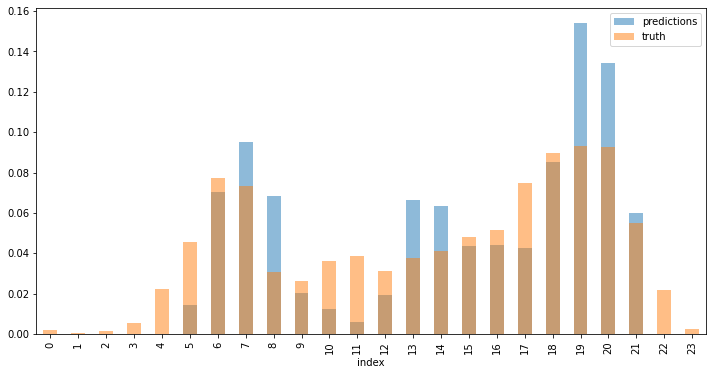

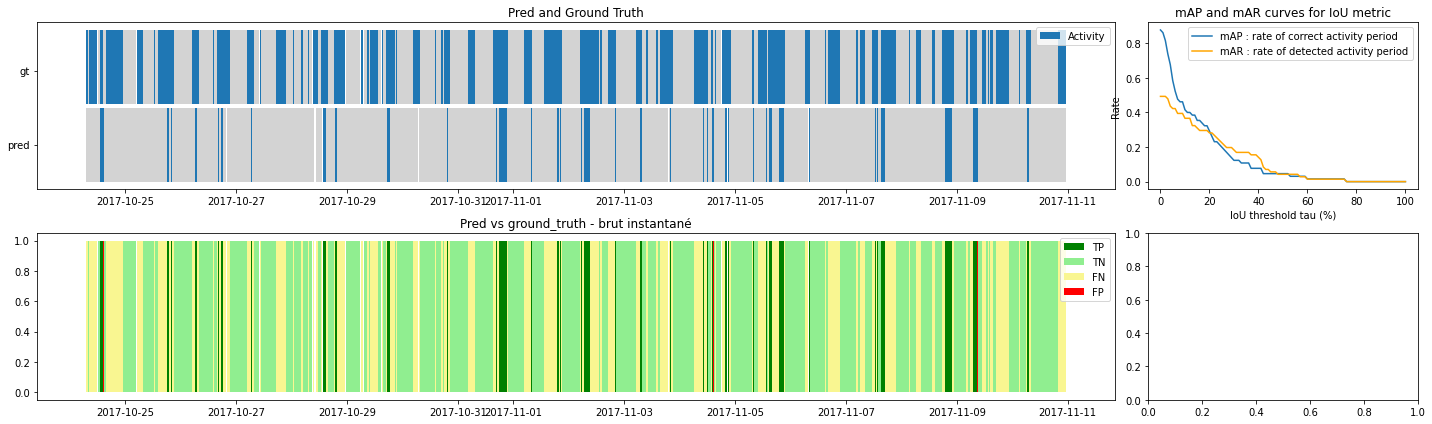

In [40]:
y_pred_h2 = kgs_t2v_c.predict(X_test_h2)
get_scores(y_test_h2, y_pred_h2, house2_power_blk1, SEQUENCE_LENGTH, OVERLAP_PERIOD)

Let's see the results on house 2 from UKDale.

Score f_beta : 80.475%
Score accuracy : 88.843%


/mnt/data/Documents/Cours Télécom/INFMDI780 - Projet Fil Rouge/Activity_Detection_From_Electrical_Consumption_Load_Curves/Time2Vec/../module.py:529: RuntimeWarning: invalid value encountered in double_scalars
  IoU = I/U


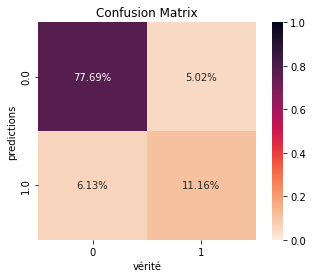

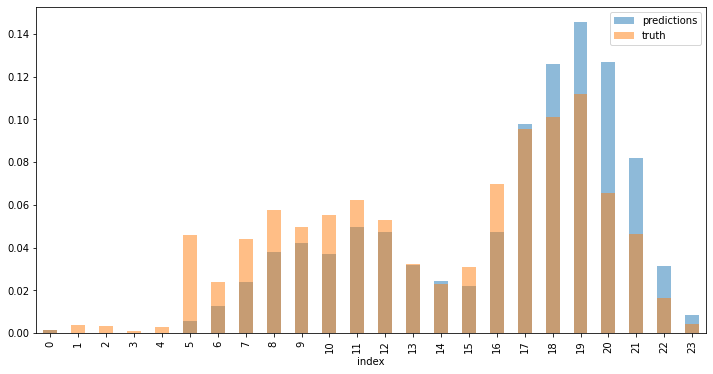

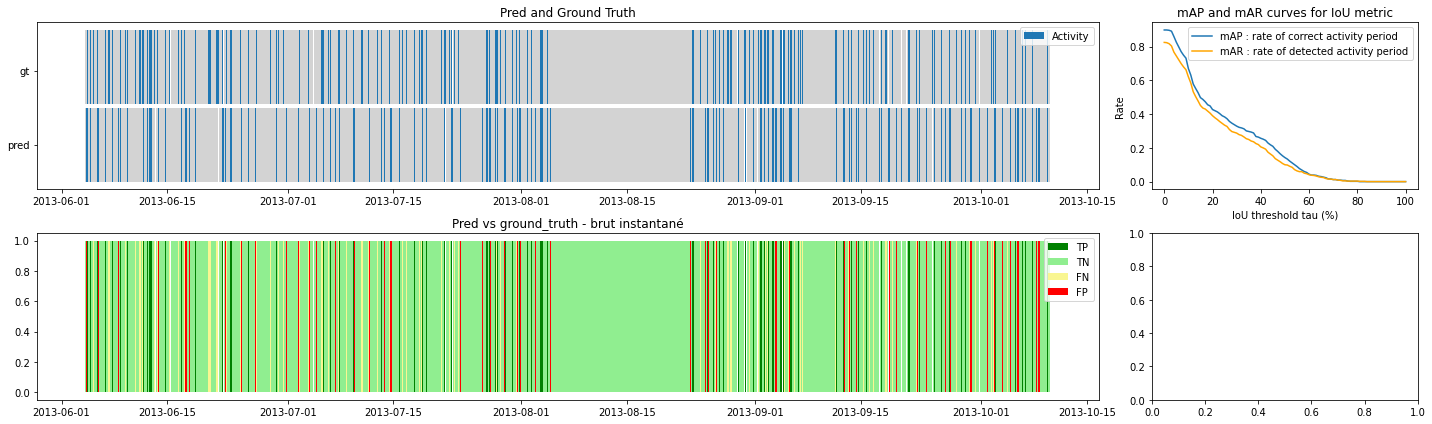

In [41]:
y_pred_h2_ukd = kgs_t2v_c.predict(X_test_h2_ukd)
get_scores(y_test_h2_ukd, y_pred_h2_ukd, house2_power_ukdale, SEQUENCE_LENGTH, OVERLAP_PERIOD, 0.1)